# Laboratorio 3 - Clasificación de Malware

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("VirusSample.csv")
df.sample(10)

,file,api,class
4759,9f5f368fe7a542236a8e0766cee236d28c8ddc2e,"CoCreateInstance,CLSIDFromString,CoInitialize,...",Trojan
7762,012e09519dbb62b0ffe6e27f097228e46453a35a,"LoadLibraryA,GetProcAddress",Trojan
6533,67a61c136413b58355038987138e621e0aba4ef0,"_CIcos,_adj_fptan,__vbaVarMove,__vbaAryMove,__...",Trojan
2633,79cc328673b78e09bcab458a75c4a86f9fadd7d9,"IsValidInterface,GetThreadLocale,GetProcessHeap",Virus
3880,3fa7b49f470a411a88a42b47d456f326ff7eea2a,"GetModuleHandleA,GetProcAddress,fabs,InitCommo...",Trojan
8606,3a1734d92f19b8da3829c86819d3df796a634a16,"ExitProcess,GetEnvironmentStringsA,CloseHandle...",Backdoor
9387,d2a630e4a23ef17691ea9a2e6ea44bfd449e34d31f78d2...,"RtlUpcaseUnicodeToMultiByteN,GetMessageTime,Ge...",Virus
7091,b66a0316f6e5b075d89cee940d3a371943595668,"DeleteCriticalSection,EnterCriticalSection,Exi...",Trojan
3411,19e044338f9b6b019f1db652a6e405042005848d,"LoadLibraryA,GetProcAddress,ExitProcess,URLDow...",Downloader
6503,9b3d714988bf47823fe8b300f8ab02eab0e4eb15,"WSAGetLastError,WSAStartup,__WSAFDIsSet,accept...",Trojan


Trojan        6153
Virus         2367
Backdoor       447
Worms          441
Adware         222
Agent          102
Downloader      31
Spyware         11
Ransomware      10
Riskware         4
Dropper          4
Crypt            2
Keylogger        1
Name: class, dtype: int64


<AxesSubplot: >

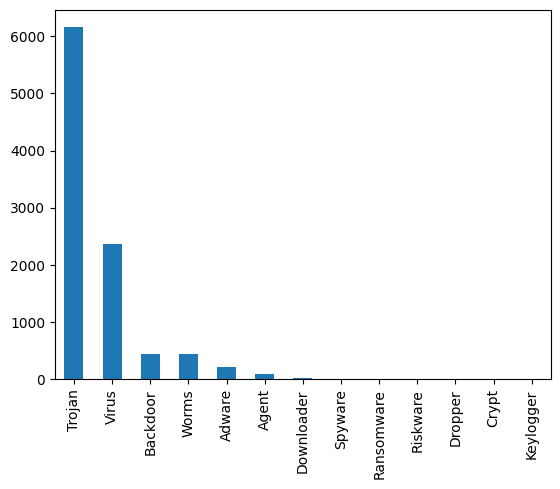

In [3]:
print(df['class'].value_counts())
df['class'].value_counts().plot(kind='bar')

In [4]:
backdoor_count = df['class'].value_counts()['Backdoor']
backdoor_count

447

Como se puede observar, los datos no estan balanceados ya que hay muchos troyanos pero hay otras categorías que no tienen muchos datos, por esta razón se toma la decisión de solo tomar las categorías que tienen más de 100 datos para evitar el sobreajuste. De las categorías que quedan se balancean para tener la misma cantidad de datos que Backdoor ya que se considera una buena cantidad para no tener que hacer mucho sobremuestreo de las categorías como agent.

## Preprocesamiento

In [5]:
df = df.drop("file", axis=1)

In [6]:
types = ['Trojan', 'Virus', 'Backdoor', 'Worms', 'Adware', 'Agent']
# Se agregan solamente los tipos que tienen por lo menos 100 muestras para evitar el sobreajuste

In [7]:
sections = []
balanced_sections = []
for t in types:
    sections.append(df[df['class'] == t])
for sec in sections:
    balanced_sections.append(sec.sample(backdoor_count, replace=True))
df2 = pd.concat(balanced_sections)
print(df2.shape)
df2.sample(10)

(2682, 2)


,api,class
2835,"CreateDialogParamA,LookupAccountNameA,SystemFu...",Virus
3599,_CorExeMain,Adware
8879,"ExitProcess,GetEnvironmentStringsA,CloseHandle...",Backdoor
9053,"MethCallEngine,EVENT_SINK_AddRef,EVENT_SINK_Re...",Worms
2957,"DeleteCriticalSection,ResetWriteWatch,GetClipb...",Virus
9217,"MethCallEngine,EVENT_SINK_AddRef,EVENT_SINK_Re...",Worms
6203,"LoadLibraryA,GetProcAddress",Trojan
1021,"LoadLibraryA,GetProcAddress,VirtualProtect,Vir...",Trojan
2241,"GetClipboardViewer,CallWindowProcW,RegisterCla...",Virus
3678,"LoadLibraryA,GetProcAddress,ExitProcess,GetAce...",Adware


Trojan      447
Virus       447
Backdoor    447
Worms       447
Adware      447
Agent       447
Name: class, dtype: int64


<AxesSubplot: >

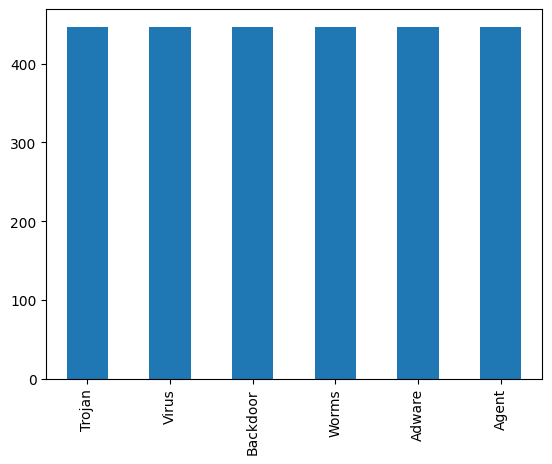

In [8]:
print(df2['class'].value_counts())
df2['class'].value_counts().plot(kind='bar')

Ahora los datos estan balanceados :)

In [9]:
body = np.array(df2['api'])
target = np.array(df2['class'])
target_dummies = np.array(pd.get_dummies(df2['class']))

In [10]:
cv = CountVectorizer(min_df=0.001)
cv_matrix = cv.fit_transform(body)
cv_matrix = cv_matrix.toarray()
vocabulario = cv.get_feature_names_out()
vocabulario.shape
bow = pd.DataFrame(cv_matrix, columns=vocabulario)
bow

,0_container_base12,0_locinfo,0_lockit,0_winit,0bad_cast,0bad_exception,0exception,0id,0init,0logic_error,...,zwclose,zwcreatefile,zwenumeratekey,zwopenkey,zwqueryfullattributesfile,zwquerysysteminformation,zwqueryvaluekey,zwreadfile,zwunloaddriver,zwwritefile
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Implementación

In [11]:
X_train, X_test, y_train, y_test = train_test_split(bow, target, test_size=0.3, random_state=104, shuffle=True)

### Support vector machines

In [12]:
model1 = SVC(gamma='auto')
model1 = model1.fit(X_train, y_train)

In [13]:
y_pred1 = model1.predict(X_test)

In [14]:
print('Matriz de confusión:\n', metrics.confusion_matrix(y_test, y_pred1))

Matriz de confusión:
 [[ 89   1   0   0  35   0]
 [ 22  96   0   7   7   0]
 [  1   0 112  14   1   2]
 [  6   4   0  67  51   4]
 [  2   0   0   1 148   0]
 [  4   0   0   0  86  45]]


In [15]:
print(metrics.classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

      Adware       0.72      0.71      0.71       125
       Agent       0.95      0.73      0.82       132
    Backdoor       1.00      0.86      0.93       130
      Trojan       0.75      0.51      0.61       132
       Virus       0.45      0.98      0.62       151
       Worms       0.88      0.33      0.48       135

    accuracy                           0.69       805
   macro avg       0.79      0.69      0.70       805
weighted avg       0.78      0.69      0.69       805



In [16]:
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
X = bow
y = df2['class']
accs = 0
    
for (train, test), i in zip(cv.split(X, y), range(10)):
    print("Starting", i, "fold")
    model1.fit(X.iloc[train], y.iloc[train])
    y_pred = model1.predict(X.iloc[test])
    y_test = y.iloc[test]
    acc = metrics.accuracy_score(y_test, y_pred)
    accs += acc
    print(i, "fold accuracy is:", acc)
    
print("After 10 folds average accuracy is:", accs/10)

Starting 0 fold
0 fold accuracy is: 0.6914498141263941
Starting 1 fold
1 fold accuracy is: 0.7434944237918215
Starting 2 fold
2 fold accuracy is: 0.7238805970149254
Starting 3 fold
3 fold accuracy is: 0.7052238805970149
Starting 4 fold
4 fold accuracy is: 0.7014925373134329
Starting 5 fold
5 fold accuracy is: 0.6791044776119403
Starting 6 fold
6 fold accuracy is: 0.7089552238805971
Starting 7 fold
7 fold accuracy is: 0.6716417910447762
Starting 8 fold
8 fold accuracy is: 0.6716417910447762
Starting 9 fold
9 fold accuracy is: 0.7313432835820896
After 10 folds average accuracy is: 0.7028227820007769


Para este modelo podemos observar con el kfolds que su accuracy es de 70% lo cual es un buen resultado para un modelo que predice 6 categorías. Ahora, con las métricas de precision y recall podemos ver bien en que está bien y en qué se equivoca el modelo.  
Si observamos las categorías de Agent, Backdoor, Trojan y Worms podemos observar que tienen una buena métrica de precision pero no tan buena en el recall, esto significa que los virus que identifica como estas categorías (positivos) estan bien identificados pero que también hay otros virus en esa categoría que no los logra identificar (positivos que el modelo identifica como negativos).  
Por otro lado en la categoría de Virus vemos todo lo opuesto, esta categoría tiene un muy buen recall pero mala precision. Esto significa que está identificando muchos como positivos (está incluyendo muchos aunque no pertenezcan a su categoría). Aunque el recall alto significa que los positivos reales si están incluidos en los que identificó.  
Este último resultado es interesante porque es muy probable que cuando se recolectó el dataset las categorías de virus que no sabían a cual pertenecían las pusieron solo bajo la categoría "virus" por lo que ahora el modelo sobreajusta un poco sobre esta categoría.

### Random forest

In [17]:
X_train, X_test, y_train, y_test = train_test_split(bow, target_dummies, test_size=0.3, random_state=104, shuffle=True)

In [18]:
model2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
model2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [19]:
y_pred2 = model2.predict(X_test)
y_pred2

array([[0.        , 0.        , 0.        , 0.78496122, 0.15473852,
        0.06030026],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.96914007, 0.        , 0.03085993, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.996     , 0.        , 0.        , 0.002     , 0.002     ,
        0.        ]])

In [20]:
y_test = np.argmax(y_test, axis=1)
y_pred2 = np.argmax(y_pred2, axis=1)

In [21]:
print('Matriz de confusión:\n', metrics.confusion_matrix(y_test, y_pred2))

Matriz de confusión:
 [[125   0   0   0   0   0]
 [  5 127   0   0   0   0]
 [  0   0 128   1   1   0]
 [  6   3   8  93   3  19]
 [  0   0   0   5 144   2]
 [  1   0   0   4   0 130]]


In [22]:
print(metrics.classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       125
           1       0.98      0.96      0.97       132
           2       0.94      0.98      0.96       130
           3       0.90      0.70      0.79       132
           4       0.97      0.95      0.96       151
           5       0.86      0.96      0.91       135

    accuracy                           0.93       805
   macro avg       0.93      0.93      0.92       805
weighted avg       0.93      0.93      0.93       805



In [23]:
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
X = bow
y = df2['class']
accs = 0
    
for (train, test), i in zip(cv.split(X, y), range(10)):
    print("Starting", i, "fold")
    y_train = y.iloc[train]
    y_test = np.array(pd.get_dummies(y.iloc[test]))
    y_test = np.argmax(y_test, axis=1)
    model2.fit(X.iloc[train], pd.get_dummies(y_train))
    y_pred = model2.predict(X.iloc[test])
    y_pred = np.argmax(y_pred, axis=1)
    acc = metrics.accuracy_score(y_test, y_pred)
    accs += acc
    print(i, "fold accuracy is:", acc)
    
print("After 10 folds average accuracy is:", accs/10)

Starting 0 fold
0 fold accuracy is: 0.9070631970260223
Starting 1 fold
1 fold accuracy is: 0.9219330855018587
Starting 2 fold
2 fold accuracy is: 0.9328358208955224
Starting 3 fold
3 fold accuracy is: 0.9253731343283582
Starting 4 fold
4 fold accuracy is: 0.917910447761194
Starting 5 fold
5 fold accuracy is: 0.9104477611940298
Starting 6 fold
6 fold accuracy is: 0.914179104477612
Starting 7 fold
7 fold accuracy is: 0.9477611940298507
Starting 8 fold
8 fold accuracy is: 0.9328358208955224
Starting 9 fold
9 fold accuracy is: 0.9253731343283582
After 10 folds average accuracy is: 0.9235712700438331


Al observar este modelo podemos ver una mejora mucho mayor comparada con el modelo de support vector machines ya que en el kfold nos da una accuracy de 92%, un resultado muy bueno. En términos de precision y recall también está bastante balanceado y tiene resultados altos, lo que significa que es bueno identificando los virus en sus categorías. La única categoría que tiene una separación mayor entre precision y recall es la categoría 3 que equivale a trojan, esta categoría tiene una alta precision y baja recall, lo que significa que está underfitted, identifica menos virus de los que debería pero los que identifica estan bien. Es posible que la razón sea porque el dataset original tenía muchos datos de troyanos y se redujo bastante para balancear el dataset pero en general está muy bien el resultado del modelo

#### Comparación con resultados del paper
El modelo de support vector machines realizado en este laboratorio no llega al resultado obtenido en el paper, ya que con los datos balanceados la accuracy del paper fue de 79% y en este laboratorio se obtuvo 70%.  
Por otro lado en el modelo desarrollado de random forest si se superó el resultado del paper, el el paper con los datos balanceados obtuvieron un 73% de accuracy mientras que el resultado obtenido en el laboratorio fue de 92%.